In [34]:
# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential # creating a linear stack of NN
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout 

# data manipulation
import pandas as pd
import numpy as np

# sklearn 
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder

# visualisation 
import cv2 
import matplotlib
import matplotlib.pyplot as plt



In [35]:
import sys
import os

# assigning main directory path to a variable
main_dir = os.path.dirname(sys.path[0])
print(main_dir)

d:\Coding


In [36]:
# location prefix of images
IMG_LOCATION = main_dir + "\\Caltech-101-CNN\\data\\101_ObjectCategories\\"

#categories we are interested in 
LABELS = set(['dalmatian','hedgehog','llama', 'panda'])

# create two lists to contain image paths and image labels
ImagePaths = []
ListLabels = []
for label in LABELS:
    for image in list(os.listdir(IMG_LOCATION + label)):
        ImagePaths = ImagePaths + [IMG_LOCATION + label + "/" + image]
        ListLabels = ListLabels + [label]

# load images and resizing them
data = []
for img in ImagePaths:
    image = cv2.imread(img)
    image = cv2.resize(image, (128,128))
    data.append(image)

# convert image data to numpy array and standardize values 
data = np.array(data, dtype = "float") / 255

The shape of data is 4 dimensional `(237, 128, 128, 3)`
- 237 : objects/images
- 128 : pixels along x axis
- 128 : pixels along y axis
- 3 : the colours R, G, B channels

That is `Sample, rows, columns, channels`

In [37]:
data.shape

(237, 128, 128, 3)

Our target will be one of the four values - 
- llama
- panda
- dalmatian
- hedgehog
so we create a np array and encode it too!

In [38]:
# also converting labels list to np array 
LablesArray = np.array(ListLabels)

# Encode labels 
enc = OrdinalEncoder()
y = enc.fit_transform(LablesArray.reshape(-1,1))

Now we need to create training and testing samples using sklearn!


In [39]:
X_train, X_test, y_train, y_test = train_test_split(data,y, test_size = 0.2, random_state= 42)

# Print shapes
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (189, 128, 128, 3)
Shape of y_train:  (189, 1)
Shape of X_test:  (48, 128, 128, 3)
Shape of y_test:  (48, 1)


let us display some of the images in our dataset

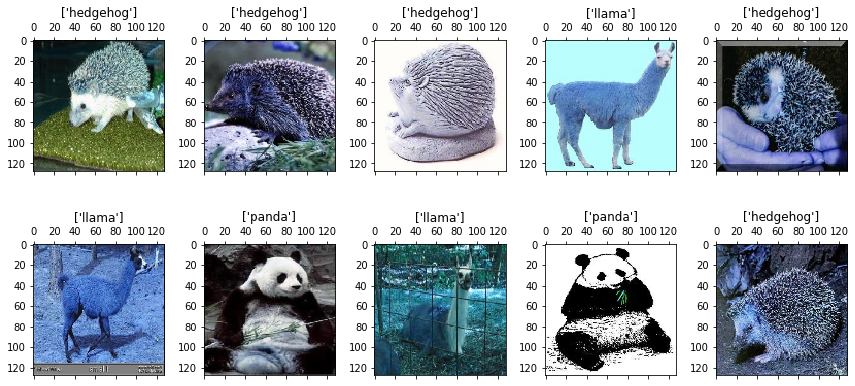

In [40]:
fig, axs = plt.subplots(2, 5, sharey= False, tight_layout = True, figsize = (12,6), facecolor = 'white')
n = 0
for i in range(0,2):
    for j in range(0, 5):
        axs[i,j].matshow(X_train[n])
        axs[i,j].set(title = enc.inverse_transform(y_train)[n])
        n += 1
plt.show()

## Training and Evaluating Deep Convolutional Network 
Some points to understand 
- initial Convolutional layers help extract the low-level features, like horizontal, vertical lines, while the later one extract high level details (eye, nose etc.)
- Structure of DCN model:
    - Input Layer
    - The first set of Conv., Max Pooling, Dropout Layer
    - The second, third set
    - Flattening the layer
    - Dense Hidden Layer
    - Output layer 
         
Here the purpose of Dropout layer is to set random amount of inputs as zero so as to avoid overfitting!

### Step 1 - Specifying the Structure of Neural Network

In [41]:
## define a model
from itertools import dropwhile


model = Sequential(name= "DCN-Model")

# input layer
# specifying the shape 
model.add(Input(
    shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]),
    name = "Input-Layer"))

# First set of Conv, MaxPooling, Dropout Layer
model.add(Conv2D(
    filters = 16,
    kernel_size = (3,3),
    strides = (1,1),
    padding='valid',
    data_format = None, 
    dilation_rate = (1,1),
    groups = 1,
    activation = 'relu',
    use_bias = True,
    kernel_initializer='glorot_uniform',
    bias_initializer="zeros",
    kernel_regularizer = None, 
    bias_regularizer=None,
    activity_regularizer=None, 
    kernel_constraint= None,
    bias_constraint=None,
    name= '2D-Convolutional-Layer-1'
))

model.add(MaxPool2D(pool_size=(2,2),
strides=(2,2),
padding= 'valid',
data_format=None,
name='2D-MaxPool_layer-1'))

model.add(Dropout(0.2, name="Dropout-Layer-1"))

#--- second set of convolution, max pooling and droput layer
model.add(Conv2D(filters= 64, kernel_size= (3,3), strides=(1,1), padding='valid', activation='relu', name='2D-Convolution-Layer'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding = 'valid', name = "2D-Max-Pool"))
model.add(Dropout(0.2, name="Dropout-Layer-2"))

# --- Third set of the same
model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', activation= 'relu', name = '2D-Convolutional-Layer-3'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2), padding = 'same', name = '2D-MaxPooling-Layer'))
model.add(Dropout(0.2, name= "Dropout-Layer-3"))

#--- Feed-Forward Densely Connected Layer and Output Layer (note, flattening is required to convert from 2D to 1D shape)
model.add(Flatten(name='Flatten-Layer')) # Flatten the shape so we can feed it into a regular densely connected layer
model.add(Dense(16, activation='relu', name='Hidden-Layer-1', kernel_initializer='HeNormal')) # Hidden Layer, relu(x) = max(x, 0)
model.add(Dense(4, activation='softmax', name='Output-Layer')) # Output Layer, softmax(x) = exp(x) / tf.reduce_sum(exp(x))

Points to note :    
- Here we can see that there are a lots of parameters that can be modified while adding a layer.    
- Each layer consists of `Conv2D, MaxPool2D, Dropout` sublayers or filters.
    - `Conv2D`: we determine the features by a matrix multiplication with smaller kernel matrix.
    - `MaxPool2D` : it takes the maxima of the local projection of kernel matrix, and resizes a matrix to a smaller dimension while maintaining the features.
    - `Dropout` : it is used to drop some of the features, so as to avoid overfitting. 

In [42]:
#   Step 2 - Compile keras model
model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
    loss='SparseCategoricalCrossentropy', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
    metrics=['Accuracy'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
    loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
    weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
    run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
    steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
    )

# step 3 - fittting the dataaset into the model
history = model.fit(X_train, # input data
    y_train, # target data
    batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
    epochs=20, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
    verbose=0, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
    callbacks=None, # default=None, list of callbacks to apply during training. See tf.keras.callbacks
    validation_split=0.0, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
    #validation_data=(X_test, y_test), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
    validation_freq=1, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
    use_multiprocessing=False, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
    )

Now the model is fitted on the dataset and now we predict! 
 
The model will give out the probabilities and we need the one, which has the maximum probablitity, for which we use `argmax`.
it will give out the tensor which will be converted to numpy array. 


In [ ]:
# we predict for training dataset first
pred_labels_tr = np.array(tf.math.argmax(model.predict(X_train),axis=1))
# Predict class labels on a test data
pred_labels_te = np.array(tf.math.argmax(model.predict(X_test),axis=1))


##### Step 5 - Model Performance Summary
print('------------------------- Model Summary -------------------------')
model.summary() # print model summary



```
6/6 [==============================] - 1s 84ms/step
2/2 [==============================] - 0s 46ms/step
------------------------- Model Summary -------------------------
Model: "DCN-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 2D-Convolutional-Layer-1 (C  (None, 126, 126, 16)     448       
 onv2D)                                                          
                                                                 
 2D-MaxPool_layer-1 (MaxPool  (None, 63, 63, 16)       0         
 ing2D)                                                          
                                                                 
 Dropout-Layer-1 (Dropout)   (None, 63, 63, 16)        0         
                                                                 
 2D-Convolution-Layer (Conv2  (None, 61, 61, 64)       9280      
 D)                                                              
                                                                 
 2D-Max-Pool (MaxPooling2D)  (None, 30, 30, 64)        0         
                                                                 
 Dropout-Layer-2 (Dropout)   (None, 30, 30, 64)        0         
                                                                 
 2D-Convolutional-Layer-3 (C  (None, 30, 30, 64)       36928     
 onv2D)                                                          
                                                                 
 2D-MaxPooling-Layer (MaxPoo  (None, 15, 15, 64)       0         
 ling2D)                                                         
                                                                 
 Dropout-Layer-3 (Dropout)   (None, 15, 15, 64)        0         
                                                                 
 Flatten-Layer (Flatten)     (None, 14400)             0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 16)                230416    
                                                                 
 Output-Layer (Dense)        (None, 4)                 68        
                                                                 
=================================================================
Total params: 277,140
Trainable params: 277,140
Non-trainable params: 0
_________________________________________________________________
```

In [54]:
print('------------------------- Encoded Names -------------------------')
for i in range(0,len(enc.categories_[0])):
    print(i,": ",enc.categories_[0][i])
print("")

print('------------------ Evaluation on Training Data ------------------')
# Print the last value in the evaluation metrics contained within history file
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")
# Print classification report
print(classification_report(y_train, pred_labels_tr))
print("")


------------------------- Encoded Names -------------------------
0 :  dalmatian
1 :  hedgehog
2 :  llama
3 :  panda

------------------ Evaluation on Training Data ------------------
Final loss : 0.019330816343426704
Final Accuracy : 0.9894179701805115

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        53
         1.0       1.00      1.00      1.00        42
         2.0       0.98      1.00      0.99        61
         3.0       1.00      0.97      0.98        33

    accuracy                           0.99       189
   macro avg       1.00      0.99      0.99       189
weighted avg       0.99      0.99      0.99       189




In [55]:

print('-------------------- Evaluation on Test Data --------------------')
print(classification_report(y_test, pred_labels_te))
print("")


-------------------- Evaluation on Test Data --------------------
              precision    recall  f1-score   support

         0.0       0.85      0.79      0.81        14
         1.0       0.67      0.83      0.74        12
         2.0       0.71      0.59      0.65        17
         3.0       0.67      0.80      0.73         5

    accuracy                           0.73        48
   macro avg       0.72      0.75      0.73        48
weighted avg       0.74      0.73      0.73        48




we can see that it works quite well on the training dataset, but it can be improved on the test dataset!    
Let's do some additional evaluation, i want to see if it works on any random picture i take from the interent.


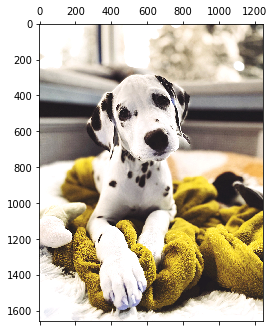

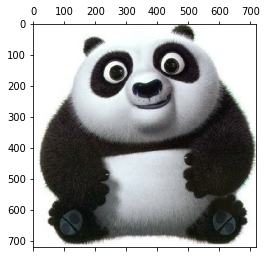

In [90]:
doggo = cv2.imread(main_dir + "\\Caltech-101-CNN\\data\\doggo_from_internet.jpg")
po_the_panda = cv2.imread(main_dir + "\\Caltech-101-CNN\\data\\po_thepanda.jpg")
plt.matshow(doggo)
plt.matshow(po_the_panda)

before we predict, we need to preprocess the image, which involves following steps: 
- resize
- standardize
- reshaping

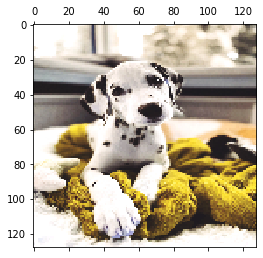

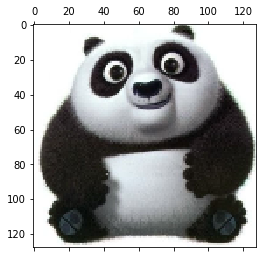

In [91]:
def preprocess_image(object_image):
    object_image = cv2.resize(object_image, (128,128))
    plt.matshow(object_image)
    object_image = object_image / 255.0

    object_image = object_image[np.newaxis, ...]
    return object_image

doggo = preprocess_image(doggo)
po_the_panda = preprocess_image(po_the_panda)

In [92]:
doggo.shape
po_the_panda.shape

(1, 128, 128, 3)

In [93]:
pred_mydog = enc.inverse_transform(np.array(tf.math.argmax(model.predict(doggo), axis = 1)).reshape(-1,1))
print("DCN Model prediction : ", pred_mydog)

pred_probs=model.predict(doggo)

# Print in a nice format with label and probability next to each other
print("")
print("Probabilities for each category:")
for i in range(0,len(enc.categories_[0])):
    print(enc.categories_[0][i], " : ", pred_probs[0][i])

1/1 [==============================] - 0s 38ms/step
DCN Model prediction :  [['dalmatian']]
1/1 [==============================] - 0s 46ms/step

Probabilities for each category:
dalmatian  :  0.9999982
hedgehog  :  2.5823194e-20
llama  :  9.594618e-07
panda  :  8.5514216e-07


In [94]:
pred_po = enc.inverse_transform(np.array(tf.math.argmax(model.predict(po_the_panda), axis = 1)).reshape(-1,1))
print("DCN Model prediction : ", pred_po)

pred_probs=model.predict(po_the_panda)

# Print in a nice format with label and probability next to each other
print("")
print("Probabilities for each category:")
for i in range(0,len(enc.categories_[0])):
    print(enc.categories_[0][i], " : ", pred_probs[0][i])

1/1 [==============================] - 0s 44ms/step
DCN Model prediction :  [['panda']]
1/1 [==============================] - 0s 35ms/step

Probabilities for each category:
dalmatian  :  2.6895164e-09
hedgehog  :  3.972652e-19
llama  :  5.952392e-07
panda  :  0.9999994


Clearly, we can see that our model predicts correctly!
Thus we can say that DCN are quite relialble, with further experiments with the parameters, increasing the size of dataset, we can improve the accuracy of DCN model!
